In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patheffects as mpe
import sciplot as sciplot
import brightway2 as bw
import bw2analyzer as bwa

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Basic set-up

In [3]:
PROJECT_NAME = 'iri'

bw.projects.set_current(PROJECT_NAME)
print(bw.projects.current) # Current project
print(bw.projects.dir) # Current project directory
print(bw.databases) # List of databases in the project

iri
C:\Users\iistrate\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90
Databases dictionary with 18 object(s):
	A_technosphere_flows
	Biogas-to-chemicals, BAU
	Biogas-to-chemicals, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)
	Digital Content Consumption
	Digital Content Consumption, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)
	Digital Content Consumption, IMAGE SSP2-RCP19, 2040 (premise v1.2.6)
	Digital Content Consumption, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)
	biosphere3
	ecoinvent 3.1 cutoff
	ecoinvent 3.5 cutoff
	ecoinvent 3.8 cutoff
	ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)
	ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2040 (premise v1.2.6)
	ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)
	ecoinvent 3.8 cutoff, IMAGE SSP2-RCP26, 2030 (premise v1.2.6)
	ecoinvent 3.8 cutoff, IMAGE SSP2-RCP26, 2040 (premise v1.2.6)
	ecoinvent 3.8 cutoff, IMAGE SSP2-RCP26, 2050 (premise v1.2.6)
	ecoinvent 3.8 cutoff, with premise inventories (v1.2.6)


In [4]:
# Name of databases used:
ei_db = 'ecoinvent 3.8 cutoff'
ei_db_2050 = 'ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)'
DigitalContent_db = 'Digital Content Consumption'
DigitalContent_db_2030 = 'Digital Content Consumption, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)'
DigitalContent_db_2040 = 'Digital Content Consumption, IMAGE SSP2-RCP19, 2040 (premise v1.2.6)'
DigitalContent_db_2050 = 'Digital Content Consumption, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)'

In [5]:
# LCIA methods:
EF_METHODS = {
              'Climate change':                   ('IPCC 2013', 'climate change', 'GWP 100a, incl. H and bio CO2'),
              'Acidification':                    ('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (ae) no LT'),
              'Eutrophication, freshwater':       ('EF v3.0 no LT', 'eutrophication: freshwater no LT', 'fraction of nutrients reaching freshwater end compartment (P) no LT'),
              'Eutrophication, marine':           ('EF v3.0 no LT', 'eutrophication: marine no LT', 'fraction of nutrients reaching marine end compartment (N) no LT'),
              'Eutrophication, terrestrial':      ('EF v3.0 no LT', 'eutrophication: terrestrial no LT', 'accumulated exceedance (AE)  no LT'),
              'Photochemical ozone formation':    ('EF v3.0 no LT', 'photochemical ozone formation: human health no LT', 'tropospheric ozone concentration increase no LT'),
              'Particulate matter':               ('EF v3.0 no LT', 'particulate matter formation no LT', 'impact on human health no LT'),
              'Ozone depletion':                  ('EF v3.0 no LT', 'ozone depletion no LT', 'ozone depletion potential (ODP)  no LT'),
              'Ecotoxicity, freshwater':          ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe)  no LT'),
              'Human toxicity, carcinogenic':     ('EF v3.0 no LT', 'human toxicity: carcinogenic no LT', 'comparative toxic unit for human (CTUh)  no LT'),
              'Human toxicity, non-carcinogenic': ('EF v3.0 no LT', 'human toxicity: non-carcinogenic no LT', 'comparative toxic unit for human (CTUh)  no LT'),
              'Ionising radiation':               ('EF v3.0 no LT', 'ionising radiation: human health no LT', 'human exposure efficiency relative to u235 no LT'), 
              'Resource use, fossils':            ('EF v3.0 no LT', 'energy resources: non-renewable no LT', 'abiotic depletion potential (ADP): fossil fuels no LT'),
              'Resource use, mineral and metals': ('EF v3.0 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT'),
              'Land use':                         ('EF v3.0 no LT', 'land use no LT', 'soil quality index no LT'),
              'Water use':                        ('EF v3.0 no LT', 'water use no LT', 'user deprivation potential (deprivation-weighted water consumption) no LT')
             }

In [6]:
# Name of assessed locations
LOCATIONS = {# Regions
             'GLO': 'World', 
             'BR': 'Brazil', 
             'CA': 'Canada',
             'CN': 'China',
             'IN': 'India',
             'RER': 'Europe',
             'US': 'United States',
             # EU countries (ordered by electricity carbon footprint):
             'NO': 'Norway',
             'CH': 'Switzerland',
             'FR': 'France',
             'DK': 'Denmark',
             'ES': 'Spain',
             'IT': 'Italy',
             'DE': 'Germany',
             'PL': 'Poland',
             'GB': 'United Kingdom',
             # Other countries
             'ZA': 'South Africa',
             'AU': 'Australia',
             'RU': 'Russia'
             }

In [7]:
# Import personal carrying capacities
LCIA_data_path = 'LCIA_EF-PB.xlsx'
EF_PB_LIMITS = pd.read_excel(LCIA_data_path, 'Carrying_capacities', skiprows=1, usecols='A,J:N', index_col=0)
EF_PB_LIMITS

,EF3.0_2020,EF3.0_2030,EF3.0_2040,EF3.0_2050,units.1
Climate change,500.563828,500.563828,500.563828,500.563828,kg CO2-eq/person/year
Acidification,128.290676,116.979760,108.709272,102.721779,mol H+-eq/person/year
"Eutrophication, freshwater",0.741520,0.676143,0.628340,0.593732,kg P-eq/person/year
"Eutrophication, marine",25.914717,23.629911,21.959273,20.749799,kg N-eq/person/year
"Eutrophication, terrestrial",786.421845,717.085928,666.387836,629.684505,mol N-eq/person/year
Photochemical ozone formation,52.214305,47.610762,44.244674,41.807764,kg NMVOC-eq/person/year
Particulate matter,0.000075,0.000075,0.000075,0.000075,disease incidence/person/year
Ozone depletion,0.069277,0.063169,0.058703,0.055470,kg CFC-11-eq/person/year
"Ecotoxicity, freshwater",16630.272844,15164.042947,14091.942637,13315.786156,CTUe/person/year
"Human toxicity, carcinogenic",0.000139,0.000139,0.000139,0.000139,CTUh/person/year


In [63]:
# Other IDs:
USERS = ['Low technology user', 'Medium technology user', 'High technology user']
DIGITAL_CONTENT = ['Web surfing', 'Social media', 'Video streaming', 'Music streaming', 'Video conferencing']
INTERNET_COMPONENTS = ['End-user devices | operation', 'End-user devices | embodied', 
                       'CPE | operation', 'CPE | embodied', 
                       'Access network', 'Core network', 
                       'Data centres | operation', 'Data centres | embodied']
END_USER_DEVICES = ['Smartphone', 'Tablet', 'Laptop', 'Desktop computer', 'TV']

Run functions to perform LCIA and contribution analysis

In [33]:
%run 00_Functions_for_results_analysis.ipynb

# LCA of digital content consumption

In [23]:
EF_LCIA_current = lcia_per_user_and_loc(USERS, LOCATIONS, DigitalContent_db, EF_METHODS)
EF_PB_current = impacts_contribution_to_PBs(USERS, LOCATIONS, EF_LCIA_current, EF_PB_LIMITS['EF3.0_2020'])

## Carbon footprint

In [29]:
carbon_footprint_loc = {}
for user in EF_LCIA_current:
    carbon_footprint_loc[user] = {}
    for loc in EF_LCIA_current[user]:
        carbon_footprint_loc[user].update({loc: EF_LCIA_current[user][loc]['Climate change']})

carbon_footprint_loc_df = pd.DataFrame(carbon_footprint_loc)
carbon_footprint_loc_df.sort_values('Medium technology user')

,Low technology user,Medium technology user,High technology user
Norway,67.886666,146.551372,206.287459
Switzerland,69.962380,150.768872,211.426822
France,71.574828,154.045093,215.419162
Canada,78.492945,168.101537,232.548071
Brazil,84.245257,179.789262,246.790505
Spain,86.107832,183.573699,251.402146
United Kingdom,87.219660,185.832744,254.154974
Denmark,87.463978,186.329158,254.759895
Europe,90.405940,192.306727,262.044044
Italy,90.589660,192.680014,262.498924


## Share of the personal carrying capacity

In [24]:
EF_PB_low = pd.DataFrame(EF_PB_current['Low technology user'])
EF_PB_medium = pd.DataFrame(EF_PB_current['Medium technology user'])
EF_PB_high = pd.DataFrame(EF_PB_current['High technology user'])

EF_PB_medium

,World,Brazil,Canada,China,India,Europe,United States,Norway,Switzerland,France,Denmark,Spain,Italy,Germany,Poland,United Kingdom,South Africa,Australia,Russia
Climate change,45.852018,35.917350,33.582438,53.771356,65.156840,38.418023,40.817105,29.277260,30.119810,30.774316,37.223856,36.673385,38.492596,41.958036,53.719796,37.124685,55.795260,51.149419,47.014772
Acidification,1.039020,0.841579,0.784473,1.234805,1.408558,0.900708,0.856184,0.711574,0.724601,0.742517,0.800834,0.964154,0.867374,0.816568,1.403993,0.796957,2.159891,1.113059,1.038011
"Eutrophication, freshwater",2.920918,2.369151,2.684775,2.681926,3.873077,2.975803,2.977124,2.326749,2.352612,2.348101,2.699983,2.541683,2.479800,3.610388,4.568790,2.414026,3.919303,5.047514,3.040950
"Eutrophication, marine",1.281524,1.108880,1.053102,1.541206,1.617611,1.125207,1.098771,1.003828,1.013249,1.033199,1.090067,1.187338,1.112884,1.097603,1.369824,1.095955,1.898412,1.324274,1.214120
"Eutrophication, terrestrial",0.317634,0.252744,0.233541,0.410532,0.452476,0.261523,0.251474,0.216062,0.220530,0.225506,0.254310,0.282910,0.258500,0.253924,0.352569,0.252432,0.550279,0.334557,0.292159
Photochemical ozone formation,1.301605,1.010552,0.965754,1.647194,1.810619,1.076942,1.050073,0.888793,0.902823,0.928451,1.017578,1.160060,1.069746,1.032365,1.466013,1.023231,2.218594,1.355650,1.253578
Particulate matter,13.372150,12.558456,9.428074,21.923999,12.384620,9.930923,10.325868,9.198859,9.246395,9.389966,10.016129,10.086237,10.135445,9.786264,10.887049,9.717017,11.914074,10.101232,10.384698
Ozone depletion,0.018430,0.017420,0.016179,0.015185,0.016145,0.017586,0.019224,0.014369,0.014851,0.015774,0.015537,0.017755,0.023169,0.016619,0.016577,0.017944,0.015573,0.016391,0.024628
"Ecotoxicity, freshwater",56.974868,50.059116,48.453724,68.071572,79.019861,50.680889,52.652348,47.656323,48.213066,49.254680,51.911392,51.118039,50.193126,50.943704,57.610196,50.269902,72.209756,55.246287,50.991333
"Human toxicity, carcinogenic",0.118442,0.110332,0.108736,0.123519,0.137291,0.114712,0.115544,0.106835,0.106694,0.108467,0.114393,0.114999,0.112396,0.115193,0.136303,0.111402,0.141493,0.121151,0.113250


In [174]:
def pb_share_fig(user, carbon_footprint, user_pb, fig_name):
    fig, axs = plt.subplot_mosaic([['CF', 'PB', 'CF_legend'],
                                   ['CF', 'PB', 'PB_legend']],
                                   figsize=(sciplot.length_fig(2)*0.9, sciplot.height_fig()*0.6), 
                                   gridspec_kw={'width_ratios': [0.2, 3, 0.1]})
    
    sns.heatmap(ax=axs['CF'], data=carbon_footprint[[user]].sort_values(user), cmap="Greens", vmin=100, vmax=400, 
                annot=True, fmt='.0f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['CF_legend'])

    df_plot = user_pb.T.sort_values('Climate change')
    sns.heatmap(ax=axs['PB'], data=df_plot, cmap="Blues", vmin=0, vmax=100, annot=True, fmt='.1f', annot_kws={"size": 7}, 
                xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', cbar=True, cbar_ax=axs['PB_legend'])
    
    for lab, annot in zip(axs['CF'].get_yticklabels(), axs['CF'].texts):
        text = lab.get_text()
        if text in ['Europe', 'World']:
            # set the properties of the ticklabel
            lab.set_weight('bold')
            # set the properties of the heatmap annot
            #annot.set_weight('bold')  
              
    axs['PB'].set_yticklabels('')
    axs['CF'].set_xticklabels(['Carbon footprint'], rotation = 45, ha="left", fontsize=sciplot.fontsize_axs())
    axs['PB'].set_xticklabels(list(df_plot.columns), rotation = 45, ha="left", fontsize=sciplot.fontsize_axs())

    for col in ['CF', 'PB']:
        axs[col].xaxis.tick_top()
        axs[col].tick_params(axis='x', which='major', direction='in', length=0, labelsize=sciplot.fontsize_axs())
        axs[col].tick_params(axis='y', which='major', direction='in', length=0, labelsize=sciplot.fontsize_axs())
    
    for col in ['CF_legend', 'PB_legend']:
        for spine in axs[col].spines.values():
            spine.set(visible=True, lw=.5, edgecolor="black")
        axs[col].tick_params(axis='y', which='major', direction='out', length=3, labelsize=sciplot.fontsize_axs())

    axs['CF_legend'].set_ylabel('Carbon footprint\n(kg CO$_2$-eq year$^{-1}$)', fontsize=sciplot.fontsize_label())
    axs['PB_legend'].set_ylabel('Share of personal\ncarrying capacity (%)', fontsize=sciplot.fontsize_label())
    
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(fig_name, dpi=600, bbox_inches='tight')
    return fig, axs

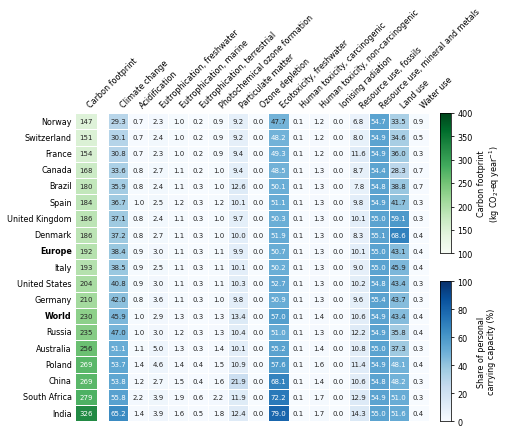

In [175]:
user = 'Medium technology user'
user_pb = EF_PB_medium
fig_name = 'EF_PB_medium.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

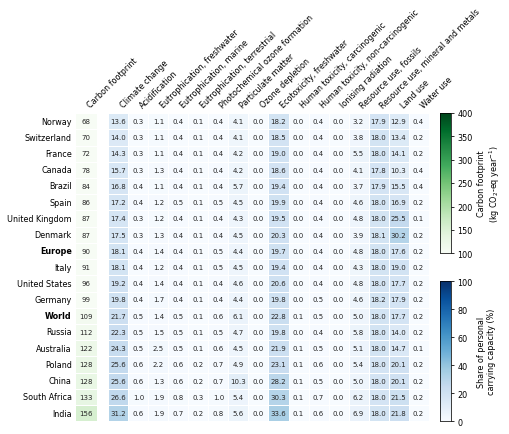

In [176]:
user = 'Low technology user'
user_pb = EF_PB_low
fig_name = 'EF_PB_low.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

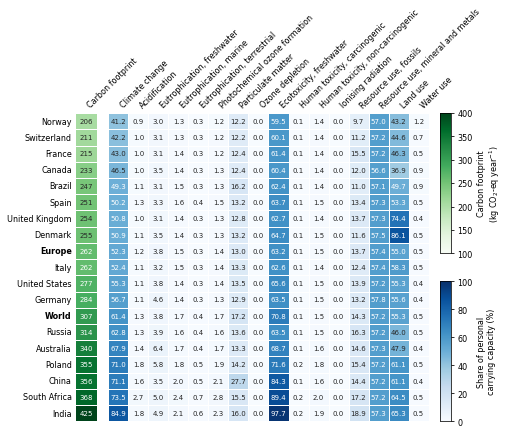

In [177]:
user = 'High technology user'
user_pb = EF_PB_high
fig_name = 'EF_PB_high.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

## Contribution analysis by system component

In [35]:
locations_CA = ['NO', 'GLO', 'IN']

In [36]:
CA_system_medium_CH_GLO_IN = {}
for loc in locations_CA:
    activity = [ds for ds in bw.Database(DigitalContent_db) if 'medium technology user' in ds['name'] and ds['location'] == loc][0]
    system_contributions = internet_system_contributions(activity, EF_METHODS, activity_amount=1)
    CA_system_medium_CH_GLO_IN[loc] = system_contributions

In [37]:
CA_system_absolute = pd.DataFrame(CA_system_medium_CH_GLO_IN['NO'])
CA_system_relative = (CA_system_absolute.T * 100 / CA_system_absolute.T.sum()).T
CA_system_relative

,End-user devices | operation,End-user devices | embodied,CPE | operation,CPE | embodied,Access network,Core network,Data centers | operation,Data centers | embodied
Climate change,1.337123,50.502771,0.433929,0.342811,0.173572,8.277217,38.223299,0.709277
Acidification,1.437387,59.758445,0.466467,0.573189,0.186587,6.511042,30.130501,0.936382
"Eutrophication, freshwater",0.555553,63.219941,0.180291,0.573266,0.072116,4.155921,30.381586,0.861326
"Eutrophication, marine",0.572613,60.970089,0.185827,0.267941,0.074331,3.661406,33.767894,0.499900
"Eutrophication, terrestrial",1.105661,60.423043,0.358814,0.487212,0.143526,6.306773,30.297702,0.877269
Photochemical ozone formation,1.111204,61.348959,0.360613,0.480808,0.144245,6.295146,29.305851,0.953174
Particulate matter,1.575034,60.153731,0.511137,0.426219,0.204455,6.207945,30.017172,0.904307
Ozone depletion,0.705596,71.530952,0.228983,0.423356,0.091593,4.616545,21.597507,0.805467
"Ecotoxicity, freshwater",1.261279,68.637002,0.409316,0.906166,0.163726,3.159457,24.160534,1.302520
"Human toxicity, carcinogenic",3.850360,71.347234,1.249536,0.667506,0.499814,3.520340,17.516319,1.348891


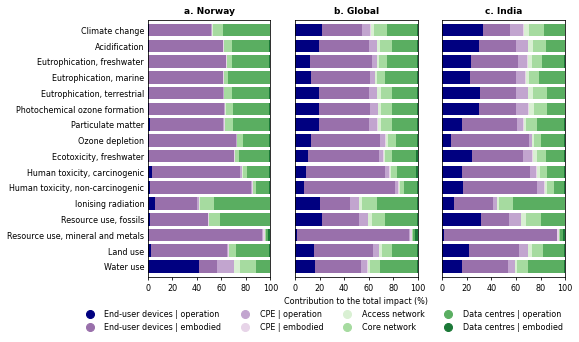

In [125]:
width=0.8
#system_color = ['#762a83', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837']
system_color = ['#b35806', '#e08214', '#fdb863', '#fee0b6', '#d8daeb', '#b2abd2', '#8073ac', '#542788']
system_color = ['navy', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837']
fig, axs = plt.subplots(1, 3, figsize=(sciplot.length_fig(2), sciplot.height_fig()*0.5), sharey=True)

count_ax = 0
for loc in locations_CA:
    ds_plot = pd.DataFrame(CA_system_medium_CH_GLO_IN[loc])
    ds_plot = (ds_plot.T * 100 / ds_plot.T.sum()).T
    
    ds_plot.plot.barh(ax=axs[count_ax], stacked=True, width=width, fontsize=sciplot.fontsize_axs(), color=system_color, legend=False, zorder=2)
    axs[count_ax].invert_yaxis()
    
    axs[count_ax].tick_params(axis='y', which='major', direction='in', length=0, labelsize=sciplot.fontsize_axs())
    axs[count_ax].tick_params(axis='x', which='major', direction='out', length=3, labelsize=sciplot.fontsize_axs())
    
    axs[count_ax].set_xlim(0, 100)
    
    count_ax += 1

axs[1].set_xlabel('Contribution to the total impact (%)', fontsize=sciplot.fontsize_label())

axs[0].set_title('a. Norway', fontweight='bold', loc='center', fontsize=sciplot.fontsize_title())
axs[1].set_title('b. Global', fontweight='bold', loc='center', fontsize=sciplot.fontsize_title())
axs[2].set_title('c. India', fontweight='bold', loc='center', fontsize=sciplot.fontsize_title())

#axs[1].annotate('', xy=(-1, 1.08), xycoords='axes fraction', xytext=(2, 1.08),
 #           arrowprops=dict(arrowstyle="<-", color='black', lw=2))
#axs[1].text(0.5, 0.97, "Carbon footprint of the electricity mix", ha="center", va="center", 
#                rotation=0, size=sciplot.fontsize_axs(), transform=fig.transFigure)

patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
              bbox_to_anchor=(2.24,-0.1), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

plt.savefig('Contribution_system.jpg', dpi=600, bbox_inches='tight')

## Contribution analysis of embodied and operational impacts of end-user devices

Only for the GLO average user

In [41]:
GLO_user_ds = [ds for ds in bw.Database(DigitalContent_db) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]

In [42]:
user_devices_embodied_lcia = user_devices_embodied_impacts(GLO_user_ds, EF_METHODS, activity_amount=1)
user_devices_operational_lcia = user_devices_operational_impacts(GLO_user_ds, EF_METHODS, activity_amount=1)

In [43]:
user_devices_embodied_lcia_df = pd.DataFrame(user_devices_embodied_lcia)
user_devices_operational_lcia_df = pd.DataFrame(user_devices_operational_lcia)

In [44]:
user_devices_embodied_total_share = (user_devices_embodied_lcia_df.T * 100 / user_devices_embodied_lcia_df.T.sum()).T
user_devices_embodied_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Climate change,14.660965,15.900765,20.990082,38.034034,10.414155
Acidification,10.821564,11.789254,19.296083,38.684836,19.408263
"Eutrophication, freshwater",17.612442,19.180786,18.991278,33.137736,11.077759
"Eutrophication, marine",8.444766,9.577513,16.315163,57.653563,8.008995
"Eutrophication, terrestrial",10.539452,11.523356,19.723803,43.314413,14.898975
Photochemical ozone formation,11.140394,11.835925,18.632282,40.037610,18.353789
Particulate matter,10.308578,11.375474,23.375572,38.725426,16.214951
Ozone depletion,22.951035,25.244854,16.508979,27.796528,7.498604
"Ecotoxicity, freshwater",6.295303,6.696839,20.892493,42.360262,23.755103
"Human toxicity, carcinogenic",11.376281,11.921286,19.468264,38.336518,18.897651


In [45]:
user_devices_operational_total_share = (user_devices_operational_lcia_df.T * 100 / user_devices_operational_lcia_df.T.sum()).T
user_devices_operational_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Climate change,3.658307,2.873907,18.431338,66.248666,8.787783
Acidification,3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, marine",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, terrestrial",3.658307,2.873907,18.431338,66.248666,8.787783
Photochemical ozone formation,3.658307,2.873907,18.431338,66.248666,8.787783
Particulate matter,3.658307,2.873907,18.431338,66.248666,8.787783
Ozone depletion,3.658307,2.873907,18.431338,66.248666,8.787783
"Ecotoxicity, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Human toxicity, carcinogenic",3.658307,2.873907,18.431338,66.248666,8.787783


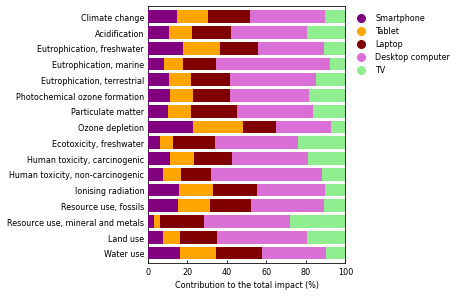

In [46]:
width=0.8
content_color = ['purple', 'orange', 'maroon', 'orchid', 'lightgreen']

fig, axs = plt.subplots(1, 1, figsize=(sciplot.length_fig(1), sciplot.height_fig()*0.5))
    
user_devices_embodied_total_share.plot.barh(ax=axs, stacked=True, width=width, fontsize=sciplot.fontsize_axs(), color=content_color, legend=False, zorder=3)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=sciplot.fontsize_axs())
axs.tick_params(axis='x', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the total impact (%)', fontsize=sciplot.fontsize_label())

patch_1 = Line2D([0], [0], color=content_color[0], label=enduser_devices[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=enduser_devices[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=enduser_devices[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=enduser_devices[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=enduser_devices[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
              bbox_to_anchor=(1,1), ncol=1, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

#plt.savefig('Contribution_embodied_devices.jpg', dpi=600, bbox_inches='tight')

## Contribution analysis by digital content

Only for the GLO user

In [47]:
CA_content_medium_GLO = digital_content_constributions(GLO_user_ds, EF_METHODS, DIGITAL_CONTENT, activity_amount=1)

In [48]:
CA_content_absolute = pd.DataFrame(CA_content_medium_GLO)
CA_content_relative = (CA_content_absolute.T * 100 / CA_content_absolute.T.sum()).T
CA_content_relative

,Web surfing,Social media,Video streaming,Music streaming,Video conferencing
Climate change,14.888964,15.090236,47.371304,11.139059,11.510437
Acidification,14.825055,14.187834,48.099994,11.165141,11.721975
"Eutrophication, freshwater",15.873401,15.456303,46.204121,11.766535,10.699641
"Eutrophication, marine",14.843674,14.137751,46.071557,11.661398,13.285620
"Eutrophication, terrestrial",15.182814,14.359847,46.699924,11.515820,12.241595
Photochemical ozone formation,14.972453,14.269764,47.546726,11.349846,11.861211
Particulate matter,15.344428,14.214078,47.002360,11.362439,12.076695
Ozone depletion,17.733636,16.901737,41.878804,13.323447,10.162376
"Ecotoxicity, freshwater",14.563029,12.527471,49.687619,10.838698,12.383183
"Human toxicity, carcinogenic",16.103560,13.737008,46.137753,12.066047,11.955633


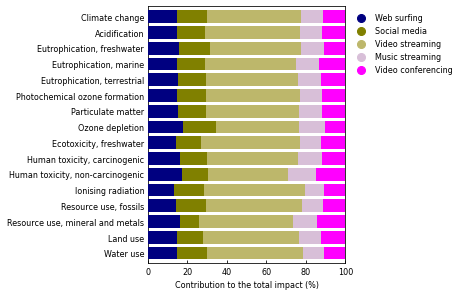

In [49]:
width=0.8
content_color = ['navy', 'olive', 'darkkhaki', 'thistle', 'fuchsia']

fig, axs = plt.subplots(1, 1, figsize=(sciplot.length_fig(1), sciplot.height_fig()*0.5))
    
CA_content_relative.plot.barh(ax=axs, stacked=True, width=width, fontsize=sciplot.fontsize_axs(), color=content_color, legend=False, zorder=3)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=sciplot.fontsize_axs())
axs.tick_params(axis='x', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the total impact (%)', fontsize=sciplot.fontsize_label())

patch_1 = Line2D([0], [0], color=content_color[0], label=digital_content[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=digital_content[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=digital_content[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=digital_content[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=digital_content[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
              bbox_to_anchor=(1,1), ncol=1, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

plt.savefig('Contribution_content.jpg', dpi=600, bbox_inches='tight')

# Prospective analysis

## Only background inventories prospective

In [47]:
EF_LCIA_2030 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DigitalContent_db_2030, EF_METHODS)
EF_LCIA_2040 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DigitalContent_db_2040, EF_METHODS)
EF_LCIA_2050 = lcia_per_user_and_loc(USERS, {'GLO': 'World'}, DigitalContent_db_2050, EF_METHODS)

In [48]:
EF_PB_2030 = impacts_contribution_to_PBs(USERS, {'GLO': 'World'}, EF_LCIA_2030, EF_PB_LIMITS['EF3.0_2030'])
EF_PB_2040 = impacts_contribution_to_PBs(USERS, {'GLO': 'World'}, EF_LCIA_2040, EF_PB_LIMITS['EF3.0_2040'])
EF_PB_2050 = impacts_contribution_to_PBs(USERS, {'GLO': 'World'}, EF_LCIA_2050, EF_PB_LIMITS['EF3.0_2050'])

In [54]:
CA_system_medium_prospective = {}
EF_METHODS_CRITICAL = {impact: EF_METHODS[impact] for impact in ['Climate change', 'Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']}

for db in [DigitalContent_db_2030, DigitalContent_db_2040, DigitalContent_db_2050]:
    CA_system_medium_prospective[db] = {}
    activity = [ds for ds in bw.Database(db) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
    CA_system_medium_prospective[db] = internet_system_contributions(activity, EF_METHODS_CRITICAL, activity_amount=1)

In [60]:
CA_system_medium_prospective

{'Digital Content Consumption, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)': {'End-user devices | operation': {'Climate change': 11.405625894581501,
   'Ecotoxicity, freshwater': 407.7413895043495,
   'Resource use, mineral and metals': 0.00025336355099,
   'Land use': 154.37948853212112},
  'End-user devices | embodied': {'Climate change': 31.865955758524528,
   'Ecotoxicity, freshwater': 4800.729413561528,
   'Resource use, mineral and metals': 0.014170077124833765,
   'Land use': 388.46241406316017},
  'CPE | operation': {'Climate change': 3.701405361671782,
   'Ecotoxicity, freshwater': 132.32208203531314,
   'Resource use, mineral and metals': 8.222268683493532e-05,
   'Land use': 50.09993067161778},
  'CPE | embodied': {'Climate change': 0.19712347010758724,
   'Ecotoxicity, freshwater': 67.0169060042232,
   'Resource use, mineral and metals': 0.00022393553400615603,
   'Land use': 3.0865598162505368},
  'Access network': {'Climate change': 1.4805620918772808,
   'Ecotoxicity, freshw

In [62]:
CA_system_medium_timeserie = {}
CA_system_medium_PB_timeserie = {}
for impact in EF_METHODS_CRITICAL:
    CA_system_medium_timeserie[impact] = {}
    
    CA_system_medium_PB_timeserie[impact] = {}
    CA_system_medium_PB_timeserie[impact]['Current'] = EF_PB_current['Medium technology user']['World'][impact]
    CA_system_medium_PB_timeserie[impact]['2030'] = EF_PB_2030['Medium technology user']['World'][impact]
    CA_system_medium_PB_timeserie[impact]['2040'] = EF_PB_2040['Medium technology user']['World'][impact]
    CA_system_medium_PB_timeserie[impact]['2050'] = EF_PB_2050['Medium technology user']['World'][impact]
    
    for system in INTERNET_COMPONENTS:
        CA_system_medium_timeserie[impact][system] = {}
        CA_system_medium_timeserie[impact][system]['Current'] = CA_system_medium_CH_GLO_IN['GLO'][system][impact]
        CA_system_medium_timeserie[impact][system]['2030'] = CA_system_medium_prospective['Digital Content Consumption, IMAGE SSP2-RCP19, 2030 (premise v1.2.6)'][system][impact]
        CA_system_medium_timeserie[impact][system]['2040'] = CA_system_medium_prospective['Digital Content Consumption, IMAGE SSP2-RCP19, 2040 (premise v1.2.6)'][system][impact]
        CA_system_medium_timeserie[impact][system]['2050'] = CA_system_medium_prospective['Digital Content Consumption, IMAGE SSP2-RCP19, 2050 (premise v1.2.6)'][system][impact]

In [1]:
prospective_categories = ['Climate change', 'Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']
categories_titles = ['a. Climate change', 'b. Ecotoxicity, freshwater',
                     'd. Resource use, mineral and metals', 'e. Land use']
categories_units = ['kg CO$_2$-eq year$^{-1}$', '10$^{4}$ CTUe year$^{-1}$',
                    '10$^{-2}$ kg Sb-eq year$^{-1}$', '10$^{3}$ Pt year$^{-1}$']
multiply_values = [1, 1e-4, 1e2, 1e-3]

fig, axs = plt.subplots(2, 2, figsize=(sciplot.length_fig(2), sciplot.height_fig()*0.6), sharex=True)

counter=0
for row in range(2):
    for col in range(2):
        axs[row,col].set_title(categories_titles[counter], fontweight='bold', loc='center', fontsize=sciplot.fontsize_title())
        axs[row,col].set_ylabel(categories_units[counter], fontsize=sciplot.fontsize_label()) 
        
        data_to_plot = [list(CA_system_medium_timeserie[prospective_categories[counter]][i].values()) for i in CA_system_medium_timeserie[prospective_categories[counter]]]
        data_to_plot = [[j*multiply_values[counter] for j in i] for i in data_to_plot]
        
        axs[row,col].stackplot([2020, 2030, 2040, 2050], data_to_plot, labels=INTERNET_COMPONENTS, colors=system_color, zorder=3)
        axs[row,col].set_ylim(ymin=0)
        
        axs1 = axs[row,col].twinx()
        axs1.plot([2020, 2030, 2040, 2050], list(CA_system_medium_PB_timeserie[prospective_categories[counter]].values()),
                  color='black', lw=2, ls='--')
        axs1.set_ylim(0,100)
        axs1.tick_params(axis='y', which='major', direction='out', length=4, labelsize=sciplot.fontsize_axs())
        axs1.set_ylabel('% of personal carrying capacity', fontsize=sciplot.fontsize_label()) 
        
        axs[row,col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=sciplot.fontsize_axs())
        axs[row,col].tick_params(axis='x', which='major', direction='out', length=4, labelsize=sciplot.fontsize_axs())
        axs[row,col].yaxis.offsetText.set_fontsize(sciplot.fontsize_axs())
        axs[row,col].set_xticks([2020, 2030, 2040, 2050], )
        axs[row,col].set_xlim(2019,2051)
    #    axs[row,col].grid(ls='--', lw=0.5, zorder=0)
        counter += 1 
        
axs[0,0].axhline(y=0, ls='-', color='black', lw=0.8)
axs[0,0].annotate(text='', xy=(2022,95), xytext=(2050.5,95), arrowprops=dict(arrowstyle='<-'))

#axs[1,0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

# LEGEND
patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1,1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
                bbox_to_anchor=(1.2,-0.21), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

line = Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Share of the personal carrying capacity')
axs[1,0].legend(handles=[line], bbox_to_anchor=(2,-0.44), frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

fig.subplots_adjust(wspace=0.7, hspace=0.3)
#plt.savefig('Prospective_lcia.jpg', dpi=600, bbox_inches='tight')

NameError: name 'plt' is not defined

In [64]:
impacts_2020_vs_2050 = pd.concat([pd.DataFrame(EF_LCIA_current['Medium technology user'])[['World']], pd.DataFrame(EF_LCIA_2050['Medium technology user'])], axis=1)
impacts_2020_vs_2050.columns = ['Current', 'P_2050']
impacts_2020_vs_2050['Diff'] = (impacts_2020_vs_2050.P_2050 - impacts_2020_vs_2050.Current) / impacts_2020_vs_2050.Current * 100
impacts_2020_vs_2050

,Current,P_2050,Diff
Climate change,2.295186e+02,4.445987e+00,-98.062908
Acidification,1.332966e+00,4.542934e-01,-65.918613
"Eutrophication, freshwater",2.165919e-02,1.107372e-02,-48.872884
"Eutrophication, marine",3.321034e-01,1.940499e-01,-41.569426
"Eutrophication, terrestrial",2.497941e+00,1.073347e+00,-57.030723
Photochemical ozone formation,6.796243e-01,3.059876e-01,-54.976939
Particulate matter,9.997869e-06,4.575674e-06,-54.233513
Ozone depletion,1.276754e-05,1.195572e-05,-6.358483
"Ecotoxicity, freshwater",9.475076e+03,6.745122e+03,-28.811946
"Human toxicity, carcinogenic",1.647883e-07,1.386081e-07,-15.887161


In [65]:
pd.DataFrame(EF_PB_2050['Medium technology user']['World'], index=['value']).T

,value
Climate change,0.888196
Acidification,0.442256
"Eutrophication, freshwater",1.865105
"Eutrophication, marine",0.935189
"Eutrophication, terrestrial",0.170458
Photochemical ozone formation,0.731892
Particulate matter,6.119963
Ozone depletion,0.021554
"Ecotoxicity, freshwater",50.655081
"Human toxicity, carcinogenic",0.099625


## Background + foreground inventories prospective with presamples

In [10]:
import presamples as ps

In [11]:
sensitivity_analysis_data = r"Data_for_sensitivity_analysis_with_presamples.xlsx"

In [12]:
def read_presamples_scenario_data(scenario_file, Ecoinvent_db, Other_db):
    """
    This function reads the scenario data from an excel file and prepares it into a dataframe for being used with Presamples.
    Secondly, it adds the bw codes for the involved activities.
    The dictionary map_bw_keys provides these codes, it needs to be generated beforehand with the involved databases.    
    """

    # Create mapping of BW codes for involved databases
    map_bw_keys = dict()
    for db in [Ecoinvent_db, Other_db]:
        db_obj = bw.Database(db)
        for ds in db_obj:
            map_bw_keys[(ds['reference product'], ds['name'], ds['location'])] = ds.key
    
    scenariodata_df = pd.read_excel(scenario_file) # Import data
    scenariodata_df = scenariodata_df.dropna(how="all") # Delete empty rows
    
    scenario_label = list(scenariodata_df.columns)[9:] # Get label of scenarios
    
    # add the bw code to your scenario DF (input = process, output = to_process)
    scenariodata_df["input"] = [map_bw_keys[(row["from_reference_product"], row["from_process"], row["from_location"])] 
                                for index, row in scenariodata_df.iterrows()]
    scenariodata_df["output"] = [map_bw_keys[(row["to_reference product"], row["to_process"], row["to_location"])] 
                                 for index, row in scenariodata_df.iterrows()]

    return scenario_label, scenariodata_df

In [13]:
def make_pspackage(scenariodata_df, scenario_label, matrixlabel, ps_packagename):
    """
    This function prepares a Presamples package out of the scenario data if.
    """
        
    # select needed data
    samples = scenariodata_df[scenario_label].values
    indices = [(row['input'], row['output'], row['from_type']) for i, row in scenariodata_df.iterrows()] 

    # Generate PS data in PSpackage
    data = [(samples, indices, matrixlabel)]
    
    ps_id, ps_filepath = ps.create_presamples_package(matrix_data=data, name=ps_packagename, seed="sequential") 
    
    print("\n ps_id, filepath:", ps_id, ps_filepath)
    
    return samples, indices, ps_filepath

In [14]:
# Read the excel file to get the scenario data
scenario_label, scenariodata_df = read_presamples_scenario_data(sensitivity_analysis_data, ei_db_2050, DigitalContent_db_2050)
scenariodata_df.head()

,to_reference product,to_process,to_location,to_database,from_reference_product,from_process,from_location,from_type,from_database,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime,input,output
0,"costumer premise equipment, internet access","costumer premise equipment, internet access",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.007000,0.003818,0.003818,0.003818,0.003818,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
1,"access network, internet access","access network, internet access",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.002800,0.001527,0.001527,0.001527,0.001527,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
2,"core network, internet access, access network ...","core network, internet access, access network ...",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",GLO,technosphere,ecoinvent,0.008858,0.004832,0.004832,0.004832,0.004832,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
3,"core network, internet access, data centers node","core network, internet access, data centers node",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",RNA,technosphere,ecoinvent,0.003440,0.001876,0.001876,0.001876,0.001876,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."
4,"core network, internet access, data centers node","core network, internet access, data centers node",GLO,Digital Content Consumption,"electricity, low voltage","market group for electricity, low voltage",RAS,technosphere,ecoinvent,0.003031,0.001653,0.001653,0.001653,0.001653,"(ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2050 ...","(Digital Content Consumption, IMAGE SSP2-RCP19..."


In [15]:
# Create PS package with indices + samples matrix
samples_v1, indices_v1, ps_filepath_v1 =  make_pspackage(scenariodata_df, scenario_label, "technosphere", "ps_v1")


 ps_id, filepath: 68211e2a741e4a5fac9287daa284972e C:\Users\iistrate\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\68211e2a741e4a5fac9287daa284972e


In [17]:
activity_for_ps = [ds for ds in bw.Database(DigitalContent_db_2050) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
activity_for_ps_lca = bw.LCA({activity_for_ps:1}, presamples=[ps_filepath_v1])

sensitivity_analysis_lcia = dict()
for impact in EF_METHODS:
    sensitivity_analysis_lcia[impact] = {}

scenario_lcia = dict()
for i in range(len(scenario_label)): # Scenarios
    if i == 0: # Don't update the first time around, since indexer already at 0th column
        activity_for_ps_lca.lci() # Builds matrices
        multi_lcia_results = dict()
        for impact in EF_METHODS:
            activity_for_ps_lca.switch_method(EF_METHODS[impact])
            activity_for_ps_lca.lcia()
            multi_lcia_results[impact] = activity_for_ps_lca.score
    else:
        activity_for_ps_lca.presamples.update_matrices() # Move to next column and update matrices
        activity_for_ps_lca.redo_lci()
        multi_lcia_results = dict()
        for impact in EF_METHODS:
            activity_for_ps_lca.switch_method(EF_METHODS[impact])
            activity_for_ps_lca.lcia()
            multi_lcia_results[impact] = activity_for_ps_lca.score
                
    scenario_lcia[scenario_label[i]] = multi_lcia_results

    for impact in EF_METHODS:
        sensitivity_analysis_lcia[impact][scenario_label[i]] = scenario_lcia[scenario_label[i]][impact]

In [19]:
sensitivity_analysis_lcia_df = pd.DataFrame(sensitivity_analysis_lcia).T
sensitivity_analysis_lcia_df

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Climate change,4.465879e+00,1.021293e+01,7.372082e+00,5.484066e+00,3.124046e+00
Acidification,4.545088e-01,3.856954e-01,3.228968e-01,2.815700e-01,2.299117e-01
"Eutrophication, freshwater",1.107907e-02,1.072392e-02,9.042123e-03,7.919863e-03,6.517038e-03
"Eutrophication, marine",1.940864e-01,1.794320e-01,1.552881e-01,1.391447e-01,1.189655e-01
"Eutrophication, terrestrial",1.073796e+00,8.660421e-01,7.378811e-01,6.526039e-01,5.460074e-01
Photochemical ozone formation,3.061228e-01,2.465670e-01,2.092177e-01,1.843915e-01,1.533588e-01
Particulate matter,4.578306e-06,3.761338e-06,3.200656e-06,2.827881e-06,2.361913e-06
Ozone depletion,1.195940e-05,9.465772e-06,8.048329e-06,7.101948e-06,5.918972e-06
"Ecotoxicity, freshwater",6.749196e+03,6.231572e+03,5.250466e+03,4.599965e+03,3.786838e+03
"Human toxicity, carcinogenic",1.386717e-07,1.233210e-07,1.030191e-07,8.963640e-08,7.290796e-08


In [20]:
sensitivity_analysis_lcia_PB = sensitivity_analysis_lcia_df.divide(EF_PB_LIMITS['EF3.0_2050'], axis=0).multiply(100)
sensitivity_analysis_lcia_PB

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Climate change,0.892170,2.040285,1.472756,1.095578,0.624105
Acidification,0.442466,0.375476,0.314341,0.274109,0.223820
"Eutrophication, freshwater",1.866005,1.806190,1.522930,1.333912,1.097640
"Eutrophication, marine",0.935365,0.864741,0.748383,0.670583,0.573333
"Eutrophication, terrestrial",0.170529,0.137536,0.117183,0.103640,0.086711
Photochemical ozone formation,0.732215,0.589764,0.500428,0.441046,0.366819
Particulate matter,6.123484,5.030790,4.280877,3.782291,3.159059
Ozone depletion,0.021560,0.017065,0.014509,0.012803,0.010671
"Ecotoxicity, freshwater",50.685677,46.798382,39.430388,34.545197,28.438708
"Human toxicity, carcinogenic",0.099670,0.088637,0.074045,0.064426,0.052403


In [21]:
sensitivity_analysis_lcia_PB

,default,energy_efficiency,energy_efficiency_25%_lifetime,energy_efficiency_50%_lifetime,energy_efficiency_100%_lifetime
Climate change,0.892170,2.040285,1.472756,1.095578,0.624105
Acidification,0.442466,0.375476,0.314341,0.274109,0.223820
"Eutrophication, freshwater",1.866005,1.806190,1.522930,1.333912,1.097640
"Eutrophication, marine",0.935365,0.864741,0.748383,0.670583,0.573333
"Eutrophication, terrestrial",0.170529,0.137536,0.117183,0.103640,0.086711
Photochemical ozone formation,0.732215,0.589764,0.500428,0.441046,0.366819
Particulate matter,6.123484,5.030790,4.280877,3.782291,3.159059
Ozone depletion,0.021560,0.017065,0.014509,0.012803,0.010671
"Ecotoxicity, freshwater",50.685677,46.798382,39.430388,34.545197,28.438708
"Human toxicity, carcinogenic",0.099670,0.088637,0.074045,0.064426,0.052403


In [343]:
for val_2020 in EF_PB_medium.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']]['World']:
    print(val_2020)

56.9748679445091
54.88325510766796
43.40728519465009


In [350]:
EF_PB_medium.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']]['World'].reset_index()

,index,World
0,"Ecotoxicity, freshwater",56.974868
1,"Resource use, mineral and metals",54.883255
2,Land use,43.407285


In [114]:
df_to_plot

,index,"Ecotoxicity, freshwater","Resource use, mineral and metals",Land use
0,default,50.685677,69.400000,98.904298
1,energy_efficiency,46.798382,67.349080,70.425616
2,energy_efficiency_25%_lifetime,39.430388,54.241220,61.478514
3,energy_efficiency_50%_lifetime,34.545197,45.537994,55.514039
4,energy_efficiency_100%_lifetime,28.438708,34.658961,48.058445


In [174]:
df_to_plot

,"Ecotoxicity, freshwater","Resource use, mineral and metals",Land use
default,50.685677,69.400000,98.904298
energy_efficiency,46.798382,67.349080,70.425616
energy_efficiency_25%_lifetime,39.430388,54.241220,61.478514
energy_efficiency_50%_lifetime,34.545197,45.537994,55.514039
energy_efficiency_100%_lifetime,28.438708,34.658961,48.058445


In [179]:
pd.concat([df_to_plot, pd.DataFrame(EF_PB_medium.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']]['World']).T])

,"Ecotoxicity, freshwater","Resource use, mineral and metals",Land use
default,50.685677,69.400000,98.904298
energy_efficiency,46.798382,67.349080,70.425616
energy_efficiency_25%_lifetime,39.430388,54.241220,61.478514
energy_efficiency_50%_lifetime,34.545197,45.537994,55.514039
energy_efficiency_100%_lifetime,28.438708,34.658961,48.058445
World,56.974868,54.883255,43.407285


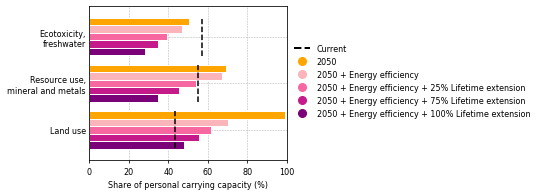

In [233]:
width=0.8

fig, axs = plt.subplots(1, 1, figsize=(sciplot.length_fig(1), sciplot.height_fig()*0.3))

sensitivity_color = ['orange', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
df_to_plot = sensitivity_analysis_lcia_PB.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']].T
df_to_plot.T.plot.barh(ax=axs, fontsize=sciplot.fontsize_axs(), color=sensitivity_color, width=width, edgecolor='white', legend=False, zorder=2)

axs.invert_yaxis()
axs.set_xlim(0, 100)

axs.axvline(x=EF_PB_medium.loc['Ecotoxicity, freshwater']['World'], ymin=0.68, ymax=0.92, ls='--', color='black', lw=1.5, zorder=3)
axs.axvline(x=EF_PB_medium.loc['Resource use, mineral and metals']['World'], ymin=0.38, ymax=0.62, ls='--', color='black', lw=1.5, zorder=3)
axs.axvline(x=EF_PB_medium.loc['Land use']['World'], ymin=0.08, ymax=0.32, ls='--', color='black', lw=1.5, zorder=3)

axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=sciplot.fontsize_axs())
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=sciplot.fontsize_axs())

axs.grid(ls='--', lw=0.5, zorder=0)
axs.set_xlabel('Share of personal carrying capacity (%)', fontsize=sciplot.fontsize_label())

labels = [item.get_text() for item in axs.get_yticklabels()]
labels[0] = 'Ecotoxicity,\nfreshwater'
labels[1] = 'Resource use,\nmineral and metals'
axs.set_yticklabels(labels)

# LEGEND
patch_0 = Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Current')
patch_1 = Line2D([0], [0], color=sensitivity_color[0], label='2050', ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=sensitivity_color[1], label='2050 + Energy efficiency', ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=sensitivity_color[2], label='2050 + Energy efficiency + 25% Lifetime extension', ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=sensitivity_color[3], label='2050 + Energy efficiency + 75% Lifetime extension', ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=sensitivity_color[4], label='2050 + Energy efficiency + 100% Lifetime extension', ls='None', marker='o', ms=8)

axs.legend(handles=[patch_0, patch_1, patch_2, patch_3, patch_4, patch_5], 
                bbox_to_anchor=(1,0.8), ncol=1, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

plt.savefig('Sensitivity_analysis.jpg', dpi=600, bbox_inches='tight')

C:\Users\iistrate\AppData\Local\Temp\ipykernel_3988\3113247222.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(labels)


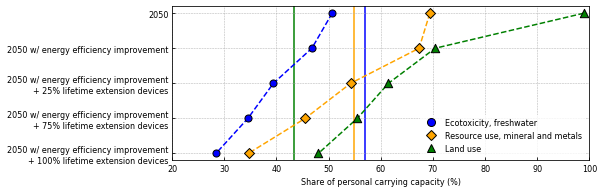

In [109]:
fig, axs = plt.subplots(1, 1, figsize=(sciplot.length_fig(2), sciplot.height_fig()*0.3))

scatter_color = ['blue', 'orange', 'green']
df_to_plot = sensitivity_analysis_lcia_PB.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']].T.reset_index()
df_to_plot.plot.scatter(ax=axs, y='index', x= 'Ecotoxicity, freshwater', marker='o', s=50, color=scatter_color[0], edgecolors= "black", fontsize=sciplot.fontsize_axs(), legend=False, zorder=3)
df_to_plot.plot.scatter(ax=axs, y='index', x= 'Resource use, mineral and metals', marker='D', s=50, color=scatter_color[1], edgecolors= "black", fontsize=sciplot.fontsize_axs(), legend=False, zorder=3)
df_to_plot.plot.scatter(ax=axs, y='index', x= 'Land use', marker='^', s=70, color=scatter_color[2], edgecolors= "black", fontsize=sciplot.fontsize_axs(), legend=False, zorder=3)

count = 0
for impact in ['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']:
    axs.plot(df_to_plot[impact], df_to_plot.index, ls='--', zorder=2, color=scatter_color[count])
    count += 1
    
axs.invert_yaxis()

axs.tick_params(axis='y', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
axs.tick_params(axis='x', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
axs.set_xlim(20, 100)

count = 0
for val_2020 in EF_PB_medium.loc[['Ecotoxicity, freshwater', 'Resource use, mineral and metals', 'Land use']]['World']:
    axs.axvline(x=val_2020, ls='-', color=scatter_color[count], lw=1.5, zorder=1)
    count += 1

labels = [item.get_text() for item in axs.get_yticklabels()]
labels[0] = '2050'
labels[1] = '2050 w/ energy efficiency improvement'
labels[2] = '2050 w/ energy efficiency improvement\n+ 25% lifetime extension devices'
labels[3] = '2050 w/ energy efficiency improvement\n+ 75% lifetime extension devices'
labels[4] = '2050 w/ energy efficiency improvement\n+ 100% lifetime extension devices'

axs.set_yticklabels(labels)
axs.grid(ls='--', lw=0.5, zorder=0)
axs.set_xlabel('Share of personal carrying capacity (%)', fontsize=sciplot.fontsize_label())
axs.set_ylabel('', fontsize=sciplot.fontsize_label())

patch_1 = Line2D([0], [0], color='blue', mec= "black", label='Ecotoxicity, freshwater', ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color='orange', mec= "black", label='Resource use, mineral and metals', ls='None', marker='D', ms=7)
patch_3 = Line2D([0], [0], color='green', mec= "black", label='Land use', ls='None', marker='^', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3], loc='lower right',
              ncol=1, frameon=True, edgecolor='white',  facecolor='White', fontsize=sciplot.fontsize_axs())
#plt.savefig('Sensitivity_analysis.jpg', dpi=600, bbox_inches='tight')

In [21]:
cci_by_country_df = pd.DataFrame(cci_by_country)
cci_by_country_df = cci_by_country_df.sort_values('Medium technology user')
cci_by_country_df

,Low technology user,Medium technology user,High technology user
Norway,72.817372,149.094016,207.080069
Switzerland,74.130451,151.689287,210.182584
France,76.908311,157.179665,216.746051
Canada,85.049647,173.270832,235.982224
Brazil,87.246485,177.612833,241.172865
Denmark,90.249323,183.547876,248.267907
United Kingdom,92.356623,187.712907,253.246990
Spain,93.367062,189.710017,255.634434
Europe,93.721332,190.410219,256.471490
Italy,96.634562,196.168158,263.354813


In [22]:
pb_cc_15 = PB_LIMITS.loc['Climate change | 1.5°C']['PB_per_capita']
cci_pb_by_country_df = cci_by_country_df.divide(pb_cc_15).multiply(100).sort_values('Medium technology user')
cci_pb_by_country_df

,Low technology user,Medium technology user,High technology user
Norway,11.637656,23.828173,33.095491
Switzerland,11.847512,24.242948,33.591334
France,12.291469,25.120419,34.640306
Canada,13.592616,27.692106,37.714627
Brazil,13.943714,28.386044,38.544194
Denmark,14.423627,29.334581,39.678122
United Kingdom,14.760415,30.000235,40.473878
Spain,14.921903,30.319413,40.855439
Europe,14.978522,30.431319,40.989217
Italy,15.444114,31.351552,42.089308


## Disaggregated

In [25]:
cci_dissg = {}
cci_dissg['By system'] = {}
cci_dissg['By online system'] = {}

for disgg in cci_dissg:
    for user in users:
        cci_dissg[disgg][user] = {}
        for loc in locations:
            if disgg == 'By system':
                cci_dissg[disgg][user].update({locations[loc]: lca_online_activities[user][locations[loc]]['CCI']['By system']})
            else:
                cci_dissg[disgg][user].update({locations[loc]: lca_online_activities[user][locations[loc]]['CCI']['By online activity']})

In [45]:
cci_by_system_medium_df = pd.DataFrame(cci_dissg['By system']['Medium technology user']).T
cci_by_system_medium_df['Total'] = cci_by_system_medium_df.sum(axis=1)
cci_by_system_medium_df = cci_by_system_medium_df.sort_values(by='Total')

cci_by_system_medium_percentage = cci_by_system_medium_df.iloc[:,:5].div(cci_by_system_medium_df.Total, axis=0).multiply(100)
cci_by_system_medium_percentage

,End-user devices,CPE,Access network,Core network,Data centers
Norway,53.919454,0.866065,0.155088,8.046675,37.012717
Switzerland,54.070408,1.140776,0.268246,8.141108,36.379462
France,54.373328,1.692038,0.495320,8.330608,35.108706
Canada,55.150545,3.106440,1.077936,8.816818,31.848261
Brazil,55.336140,3.444192,1.217061,8.932922,31.069684
Denmark,55.575624,3.880012,1.396583,9.082739,30.065042
United Kingdom,55.734644,4.169401,1.515787,9.182218,29.397950
Spain,55.808417,4.303654,1.571088,9.228368,29.088473
Europe,55.833915,4.350058,1.590202,9.244320,28.981505
Italy,56.036695,4.719082,1.742210,9.371175,28.130838


In [92]:
countries_plot = ['Switzerland', 'France', 'Canada', 'United Kingdom', 'Europe', 'United States', 'World', 'China', 'India']
countries_cci_plot = {}
for country in countries_plot:
    loc = [k for (k,v) in locations.items() if v == country][0]
    elec_ds = [ds for ds in bw.Database(ei_db) if ds['name'] in ['market for electricity, low voltage', 'market group for electricity, low voltage']
                                                                 and ds['location'] == loc][0]
    lca = bw.LCA({elec_ds: 1}, EF_methods['Climate change'])
    lca.lci()
    lca.lcia()
    countries_cci_plot[country] = lca.score,2

KeyboardInterrupt: 

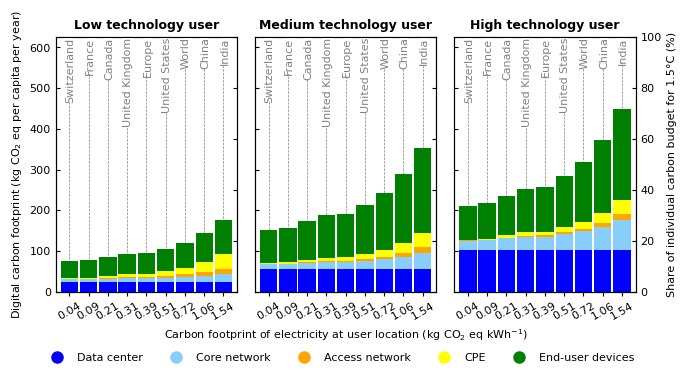

In [334]:
width=0.9

fig, axs = plt.subplots(1, 3, figsize=(sciplot.length_fig(2), sciplot.height_fig()*0.35), sharey=True)

count_ax = 0
for user in users:
    axs[count_ax].set_title(user, fontweight='bold', loc='center', fontsize=sciplot.fontsize_title())
    
    df_to_plot = pd.DataFrame(cci_dissg['By system'][user]).T
    df_to_plot['Total'] = df_to_plot.sum(axis=1)
    df_to_plot = df_to_plot.sort_values('Total').drop(['Total'], axis=1).loc[list(countries_cci_plot.keys())]
    df_to_plot = pd.concat([df_to_plot, pd.DataFrame(countries_cci_plot, ['CCI_ELEC']).T], axis=1)
    df_to_plot = df_to_plot.reset_index(drop=True).set_index('CCI_ELEC')

    df_to_plot[['Data centers', 'Core network', 'Access network', 'CPE', 'End-user devices']].plot.bar(ax=axs[count_ax], stacked=True, width=width, fontsize=sciplot.fontsize_axs(), 
                                                                                                       color=system_color, legend=False, zorder=3)
        
    axs[count_ax].set_xlabel('')
    
    
    axs[count_ax].tick_params(axis='y', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
    axs[count_ax].tick_params(axis='x', which='major', direction='out', length=3, labelsize=sciplot.fontsize_axs(), rotation=30)
    axs[count_ax].grid(axis='x', ls='--', color='grey', lw=0.5)
    
    
    
    axs1 = axs[count_ax].twinx()
    axs1.set_ylim(0, 100)
    axs1.tick_params(axis='y', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
    if count_ax < 2:
        axs1.set_yticklabels([])
    
    counter = 0
    for country in countries_plot:
        space_x = -0.2 + counter
        space_y = 625
        axs[count_ax].annotate(text=country, xy=(space_x, space_y), fontsize=sciplot.fontsize_axs(), verticalalignment='top', rotation=90, zorder=3,
                               color='grey', bbox=dict(boxstyle="square,pad=0", fc="white", ec="none", lw=0.8)) 
        counter += 1
        
    count_ax += 1
    
axs[0].set_ylim(0, pb_cc_15)

axs[0].set_ylabel('Digital carbon footprint (kg CO$_2$ eq per capita per year)', fontsize=sciplot.fontsize_label())
axs[1].set_xlabel('Carbon footprint of electricity at user location (kg CO$_2$ eq kWh$^{-1}$)', fontsize=sciplot.fontsize_label())
axs1.set_ylabel('Share of individual carbon budget for 1.5°C (%)', fontsize=sciplot.fontsize_label())

patch_1 = Line2D([0], [0], color=system_color[0], label='Data center', ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label='Core network', ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label='Access network', ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label='CPE', ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label='End-user devices', ls='None', marker='o', ms=8)

axs[1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], bbox_to_anchor=(2.15,-0.2), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

fig.subplots_adjust(wspace=0.1)
#plt.savefig('digital_carbon_footprint_by_system.jpg', dpi=600, bbox_inches='tight')

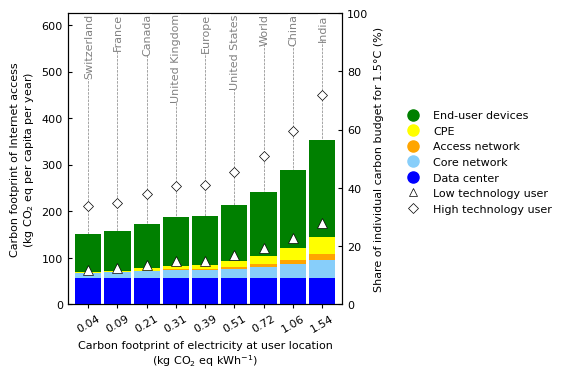

In [335]:
width=0.9

fig, axs = plt.subplots(1, 1, figsize=(sciplot.length_fig(1), sciplot.height_fig()*0.4))

count_ax = 0
    
df_to_plot = pd.DataFrame(cci_dissg['By system']['Medium technology user']).T
df_to_plot['Total'] = df_to_plot.sum(axis=1)
df_to_plot = df_to_plot.sort_values('Total').drop(['Total'], axis=1).loc[list(countries_cci_plot.keys())]
df_to_plot = pd.concat([df_to_plot, pd.DataFrame(countries_cci_plot, ['CCI_ELEC']).T], axis=1)
df_to_plot = df_to_plot.reset_index(drop=True).set_index('CCI_ELEC')
df_to_plot[['Data centers', 'Core network', 'Access network', 'CPE', 'End-user devices']].plot.bar(ax=axs, stacked=True, width=width, fontsize=sciplot.fontsize_axs(), 
                                                                                                   color=system_color, legend=False, zorder=3)

low_user_totals = cci_by_country_df.loc[list(countries_cci_plot.keys())][['Low technology user']].values
axs.plot(np.arange(len(countries_cci_plot)), low_user_totals, zorder=3, ls='None', ms=7, marker='^', mew=0.5, color='white', mec='black')

high_user_totals = cci_by_country_df.loc[list(countries_cci_plot.keys())][['High technology user']].values
axs.plot(np.arange(len(countries_cci_plot)), high_user_totals, zorder=3, ls='None', ms=5, marker='D', mew=0.5, color='white', mec='black')

axs.set_xlabel('')
    
axs.tick_params(axis='y', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=sciplot.fontsize_axs(), rotation=30)
axs.grid(axis='x', ls='--', color='grey', lw=0.5)
    
     
axs1 = axs.twinx()
axs1.set_ylim(0, 100)
axs1.tick_params(axis='y', which='major', direction='in', length=3, labelsize=sciplot.fontsize_axs())
    
counter = 0
for country in countries_plot:
    space_x = -0.15 + counter
    space_y = 625
    axs.annotate(text=country, xy=(space_x, space_y), fontsize=sciplot.fontsize_axs(), verticalalignment='top', rotation=90, zorder=3,
                               color='grey', bbox=dict(boxstyle="square,pad=0", fc="white", ec="none", lw=0.8)) 
    counter += 1

axs.set_ylim(0, pb_cc_15)

axs.set_ylabel('Carbon footprint of Internet access\n(kg CO$_2$ eq per capita per year)', fontsize=sciplot.fontsize_label())
axs.set_xlabel('Carbon footprint of electricity at user location\n(kg CO$_2$ eq kWh$^{-1}$)', fontsize=sciplot.fontsize_label())
axs1.set_ylabel('Share of individual carbon budget for 1.5°C (%)', fontsize=sciplot.fontsize_label())

patch_1 = Line2D([0], [0], color=system_color[0], label='Data center', ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label='Core network', ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label='Access network', ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label='CPE', ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label='End-user devices', ls='None', marker='o', ms=8)

patch_6 = Line2D([], [], color='white', marker='^', mec='black', ls='None', ms=6, mew=0.5, label='Low technology user')
patch_7 = Line2D([], [], color='white', marker='D', mec='black', ls='None', ms=5, mew=0.5, label='High technology user')


axs.legend(handles=[patch_5, patch_4, patch_3, patch_2, patch_1, patch_6, patch_7], bbox_to_anchor=(1.8,0.7), 
           ncol=1, frameon=False, edgecolor='black',  facecolor='White', fontsize=sciplot.fontsize_axs())

fig.subplots_adjust(wspace=0.1)
plt.savefig('digital_carbon_footprint_by_system_medium.jpg', dpi=600, bbox_inches='tight')